<a href="https://colab.research.google.com/github/manthan-mehta/ImageClassification/blob/master/two_layer_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [0]:
class TwoLayerNet(object):
  
  def __init__(self,input_size,hidden_size,output_size,std=1e-4):
    self.params = {}
    self.params['w1'] = std * np.random.randn(input_size,hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['w2'] = std * np.random.randn(hidden_size,output_size)
    self.params['b2'] = np.zeros(output_size)

  def loss(self,x,y=None,reg=0.0):
    w1 = self.params['w1']
    b1 = self.params['b1']
    w2 = self.params['w2']
    b2 = self.params['b2']
    n,dim = x.shape

    #Forward Pass
    scores = None
    f1 = x.dot(w1) + b1
    x1 = np.maximum(0,f1) #Activation - Relu
    scores = x1.dot(w2) + b2

    if y is None :
      return scores 

    #Loss Calculation
    scores -= np.max(scores,axis=1 ,keepdims=True)
    scores_exp = np.exp(scores)
    softmax_matrix = scores_exp / np.sum(scores_exp,axis =1,keepdims=True)

    

    loss = None
    loss = np.sum(-np.log(softmax_matrix[np.arange(n),y]))
    loss /=n
    loss += reg*(np.sum(w1*w1) + np.sum(w2*w2))
    
    #gradient

    #Finding delta of last layer 
    softmax_matrix[np.arange(n),y] -= 1

    softmax_matrix /= n;

    dw2 = x1.T.dot(softmax_matrix)
    db2 = softmax_matrix.sum(axis=0)

    dw1 = softmax_matrix.dot(w2.T)
    df1 = dw1 * (f1>0)
    dw1 = x.T.dot(df1)

    db1 = df1.sum(axis=0)

    dw1 += reg*2*w1
    dw2 += reg*2*w2

    grads = {'w1':dw1 , 'b1':db1 ,'w2':dw2 , 'b2':db2}
    return loss,grads

  def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100,
            batch_size=200, verbose=False):
    num_train = X.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)

    # Use SGD to optimize the parameters in self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for it in range(num_iters):
      X_batch = None
      y_batch = None
      batch_indices = np.random.choice(num_train, batch_size)
      X_batch = X[batch_indices]
      y_batch = y[batch_indices]
      
      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
      loss_history.append(loss)

      for key in self.params:
        self.params[key] -= learning_rate * grads[key]
    
      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(X_batch) == y_batch).mean()
        val_acc = (self.predict(X_val) == y_val).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Decay learning rate
        learning_rate *= learning_rate_decay

    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, X):
    y_pred = None
    y_pred = np.argmax( self.loss(X), axis=1)
    return y_pred

In [0]:
def load_cifar10(cifar10_folder_path,batch_id):
  import pickle
  with open(cifar10_folder_path + '/data_batch_' +str(batch_id),'rb') as fo:
    dict = pickle.load(fo,encoding='latin1')
  return dict

In [0]:
train = None
Y_train = []
for i in range(1,6):
  dict1 = load_cifar10('/content',1)
  if i==1:
    train = dict1['data']
  else:
    train = np.vstack((train,dict1['data']))
  Y_train += dict1['labels']

In [109]:
X_train = train.reshape((len(train), 3, 32, 32)).transpose(0, 2, 3, 1)
Y_train = np.asarray(Y_train)
print(Y_train.shape)

(50000,)


In [110]:
import pickle
with open('/content/test_batch','rb') as fo:
    test_data = pickle.load(fo,encoding='latin1')
X_test = test_data['data'].reshape((len(test_data['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
Y_test = np.asarray(test_data['labels'])
print(X_train.shape)

(50000, 32, 32, 3)


In [111]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
Y_val = Y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
Y_train = Y_train[mask]

X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (10000, 3072)


In [104]:
# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
Y_test = Y_test[mask]

mean_image = np.mean(X_train,axis=0)
mean_image = mean_image.astype('uint8')

X_train -= mean_image
X_test -= mean_image
X_val -= mean_image

input_size = 32 * 32 * 3
hidden_size = 80
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, Y_train, X_val, Y_val,
            num_iters=2000, batch_size=512,
            learning_rate=1.000000e-03, learning_rate_decay=0.95,
            reg=1.500000e-01, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == Y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 2000: loss 2.302974
iteration 100 / 2000: loss 2.178575
iteration 200 / 2000: loss 2.217067
iteration 300 / 2000: loss 2.130295
iteration 400 / 2000: loss 2.171455
iteration 500 / 2000: loss 2.073223
iteration 600 / 2000: loss 2.130693
iteration 700 / 2000: loss 2.084444
iteration 800 / 2000: loss 2.071549
iteration 900 / 2000: loss 1.942055
iteration 1000 / 2000: loss 1.967008
iteration 1100 / 2000: loss 2.115938
iteration 1200 / 2000: loss 1.925452
iteration 1300 / 2000: loss 1.972948
iteration 1400 / 2000: loss 1.902138
iteration 1500 / 2000: loss 1.922268
iteration 1600 / 2000: loss 1.959098
iteration 1700 / 2000: loss 1.886447
iteration 1800 / 2000: loss 2.062449
iteration 1900 / 2000: loss 1.886856
Validation accuracy:  0.315


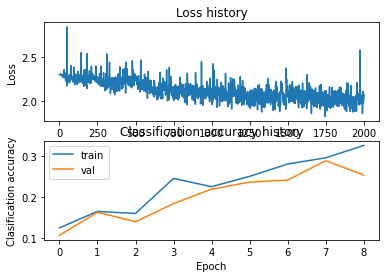

In [99]:
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

In [0]:
from math import sqrt, ceil
import numpy as np

def visualize_grid(Xs, ubound=255.0, padding=1):
  """
  Reshape a 4D tensor of image data to a grid for easy visualization.
  Inputs:
  - Xs: Data of shape (N, H, W, C)
  - ubound: Output grid will have values scaled to the range [0, ubound]
  - padding: The number of blank pixels between elements of the grid
  """
  (N, H, W, C) = Xs.shape
  grid_size = int(ceil(sqrt(N)))
  grid_height = H * grid_size + padding * (grid_size - 1)
  grid_width = W * grid_size + padding * (grid_size - 1)
  grid = np.zeros((grid_height, grid_width, C))
  next_idx = 0
  y0, y1 = 0, H
  for y in range(grid_size):
    x0, x1 = 0, W
    for x in range(grid_size):
      if next_idx < N:
        img = Xs[next_idx]
        low, high = np.min(img), np.max(img)
        grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
        # grid[y0:y1, x0:x1] = Xs[next_idx]
        next_idx += 1
      x0 += W + padding
      x1 += W + padding
    y0 += H + padding
    y1 += H + padding
  # grid_max = np.max(grid)
  # grid_min = np.min(grid)
  # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
  return grid


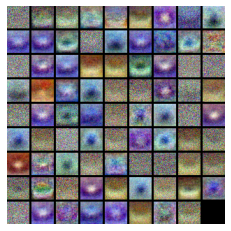

In [101]:
def show_net_weights(net):
    W1 = net.params['w1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

In [89]:
best_net = None # store the best model into this 
best_val = -1
best_stats = []
def random_search_hyperparams(lr_values, reg_values, h_values):
    lr = lr_values[np.random.randint(0,len(lr_values))]
    reg = reg_values[np.random.randint(0,len(reg_values))]
    hidden = h_values[np.random.randint(0,len(h_values))]
    return lr, reg, hidden

input_size = 32 * 32 * 3
num_classes = 10

# Set a seed for results reproduction
np.random.seed(0)

# Use of random search for hyperparameter search
for i in range(20):
    lr, reg, hidden_size = random_search_hyperparams([0.001], [0.05, 0.1, 0.15], [50, 80, 100, 120, 150, 180, 200])
    
    # Create a two-layer network
    net = TwoLayerNet(input_size, hidden_size, num_classes)
    
    # Train the network
    stats = net.train(X_train, Y_train, X_val, Y_val,
                num_iters=2000, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, verbose=False)

    # Predict on the training set
    train_accuracy = (net.predict(X_train) == Y_train).mean()
    
    # Predict on the validation set
    val_accuracy = (net.predict(X_val) == Y_val).mean()
    
    # Save best values
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_net = net
        best_stats = stats
    
    # Print results
    print('lr %e reg %e hid %d  train accuracy: %f val accuracy: %f' % (
                lr, reg, hidden_size, train_accuracy, val_accuracy))
print('best validation accuracy achieved: %f' % best_val)

lr 1.000000e-03 reg 5.000000e-02 hid 180  train accuracy: 0.275041 val accuracy: 0.263000
lr 1.000000e-03 reg 1.500000e-01 hid 200  train accuracy: 0.331469 val accuracy: 0.313000
lr 1.000000e-03 reg 1.500000e-01 hid 80  train accuracy: 0.394694 val accuracy: 0.390000
lr 1.000000e-03 reg 1.000000e-01 hid 80  train accuracy: 0.355571 val accuracy: 0.342000
lr 1.000000e-03 reg 1.500000e-01 hid 100  train accuracy: 0.322571 val accuracy: 0.334000
lr 1.000000e-03 reg 5.000000e-02 hid 150  train accuracy: 0.340592 val accuracy: 0.326000
lr 1.000000e-03 reg 1.000000e-01 hid 150  train accuracy: 0.363388 val accuracy: 0.354000
lr 1.000000e-03 reg 1.500000e-01 hid 180  train accuracy: 0.350041 val accuracy: 0.343000
lr 1.000000e-03 reg 5.000000e-02 hid 120  train accuracy: 0.376327 val accuracy: 0.365000
lr 1.000000e-03 reg 1.500000e-01 hid 200  train accuracy: 0.364224 val accuracy: 0.378000
lr 1.000000e-03 reg 1.500000e-01 hid 150  train accuracy: 0.353122 val accuracy: 0.347000
lr 1.000000e

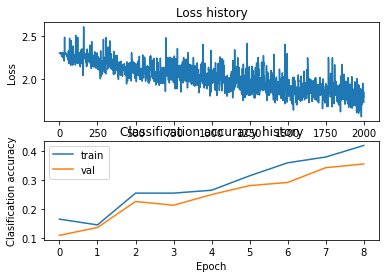

In [90]:
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()